In [1]:
import os
from pathlib import Path
import pandas as pd
import torch
import torchaudio
import torchvision
import numpy as np
from torchvision import models
import torchaudio
import matplotlib.pyplot as plt
from tqdm import tqdm
import timm
import gc
import librosa

In [2]:
data_dir = Path('/kaggle/input/tb-coughs-audio/data')
solicited = data_dir/'solicited'
TRAIN_FOLDER = solicited
cv_train = False # cross-validation or one fold

In [3]:
MODEL_FOLDER = Path('./models')

os.makedirs(MODEL_FOLDER, exist_ok=True)

# Prepare data

In [4]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import torchaudio

data_dir = Path('/kaggle/input/tb-tab-data')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
def get_sample_length(fn,base_path):
    p = base_path/fn
    x, sr = torchaudio.load(str(p))
    return x.shape[1]

In [6]:
def find_path(filename,directory_path=data_dir):
    l = list(directory_path.glob("**/" + filename))
    if len(l) == 0:
        return None
    elif len(l) == 1:
        return l[0]
    else:
        return l

In [7]:
solicited_df = pd.read_csv(find_path('CODA_TB_Solicited_Meta_Info.csv'))
clinical_df = pd.read_csv(find_path('CODA_TB_Clinical_Meta_Info.csv'))

In [8]:
#add tb_status
df = pd.merge(solicited_df, clinical_df[['participant', 'tb_status']], on = 'participant', how = 'inner')
# reset index so that .loc and .iloc are same for index
df.reset_index(drop=True,inplace=True)
#add orig_id
df['orig_id'] = df.index

n_folds = 5
seed = 2023



skf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['tb_status'], groups = df["participant"])):
    df.loc[val_idx, 'fold'] = fold
    
display(df.groupby(['fold','tb_status'])['filename'].count())

fold  tb_status
0.0   0            1343
      1             548
1.0   0            1392
      1             517
2.0   0            1352
      1             684
3.0   0            1378
      1             621
4.0   0            1377
      1             560
Name: filename, dtype: int64

In [9]:
df.to_csv("metadata.csv")


## Load the metadata

In [10]:
df = pd.read_csv("metadata.csv",index_col=[0])

In [11]:
df

,participant,filename,sound_prediction_score,tb_status,orig_id,fold
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254,0,0,2.0
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272,0,1,2.0
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112,0,2,2.0
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152,0,3,2.0
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039,0,4,2.0
...,...,...,...,...,...,...
9767,CODA_TB_1107,1658214018804-recording-1.wav,0.941761,0,9767,0.0
9768,CODA_TB_1107,1658213992939-recording-1.wav,0.904569,0,9768,0.0
9769,CODA_TB_1107,1658213992139-recording-1.wav,0.934713,0,9769,0.0
9770,CODA_TB_1107,1658213940569-recording-1.wav,0.912813,0,9770,0.0


In [12]:
df['path'] = "/kaggle/input/tb-coughs-audio/data/solicited/" + df['filename']

## Datasets

In [13]:
#add samples
df['samples'] = df.apply(lambda row: get_sample_length(row['filename'],solicited ), axis=1)
df

,participant,filename,sound_prediction_score,tb_status,orig_id,fold,path,samples
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254,0,0,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272,0,1,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112,0,2,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152,0,3,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039,0,4,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
...,...,...,...,...,...,...,...,...
9767,CODA_TB_1107,1658214018804-recording-1.wav,0.941761,0,9767,0.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
9768,CODA_TB_1107,1658213992939-recording-1.wav,0.904569,0,9768,0.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
9769,CODA_TB_1107,1658213992139-recording-1.wav,0.934713,0,9769,0.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
9770,CODA_TB_1107,1658213940569-recording-1.wav,0.912813,0,9770,0.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050


In [14]:
#Librosa version
class Dataset_from_df(torch.utils.data.Dataset):
    def __init__(self, file_df, path, crop_length=22050):
        self.file_df = file_df
        self.path = path
        self.crop_length = crop_length
        

    def __len__(self):
        return len(self.file_df)

    def __getitem__(self, index):
        def _randint(a, b):
            return torch.randint(a, b, (1, )).item()
        

        target = self.file_df.iloc[index]['tb_status']*1.0
        length = self.file_df.iloc[index]['samples']
        

        p = self.file_df.iloc[index]['path']
        orig_id = self.file_df.iloc[index]['orig_id']

        if length == self.crop_length:
            x, sr = librosa.load(str(p),sr=None)
            
        elif length < self.crop_length:
            s, sr = librosa.load(str(p),sr=None)

            zeros_front = (_randint(0, self.crop_length - length))
            pad_front = np.zeros(( zeros_front))
            pad_back = np.zeros(( self.crop_length - length - zeros_front))
            waveform = np.concatenate((pad_front, s, pad_back), 0)
            x = waveform    
            
            
            
        else:
            crop_start = _randint(0, int(length - self.crop_length))
            x, sr = librosa.load(str(p),sr=None)
            x = x[crop_start:self.crop_length+crop_start]
            
        # transform sound sample to spectrum
        x = np.abs(librosa.stft(x,n_fft = 1024,hop_length=64,window ='hanning'))
        x = librosa.amplitude_to_db(x).astype(np.float32)
        x = (x-np.min(x))/(np.max(x)-np.min(x))
        x = np.flip(x[1:349,:],0).copy() # approx 50Hz to 15000Hz
  
        
        x=torch.from_numpy(x).unsqueeze(0)
        #print(x.shape)

        return {'x':x, 'sr':sr, 'target':torch.FloatTensor([target, 1.0-target]),'orig_id':orig_id}
    

In [15]:
def prepare_datasets(df_sol, fold):
    
    df_train = df_sol
    df_valid = df_sol
    train_df = df_train.query("fold!=@fold").reset_index(drop=True)
    valid_df = df_valid.query("fold==@fold").reset_index(drop=True)
    
    #balance the data set using resampling
    df_counts = pd.DataFrame(train_df.groupby(['tb_status']).size().reset_index()).rename(columns={0:"counts"})
    df_counts['weights'] = df_counts['counts'].max() / df_counts['counts']
    df_balanced = pd.merge(train_df, df_counts[['tb_status','weights']], on='tb_status')
    sampler = torch.utils.data.WeightedRandomSampler(df_balanced['weights'].values, len(df_balanced))

    train_dataset = Dataset_from_df(train_df,TRAIN_FOLDER)
    valid_dataset = Dataset_from_df(valid_df,TRAIN_FOLDER)
    
    return train_dataset, valid_dataset, sampler

## Define the network

In [16]:
#A transform that turns a grayscale (1 channel) image to a 3 channel image
class ChannelExpand(torch.nn.Module):
    def __init__(self, channels):
        super(ChannelExpand, self).__init__()
        self.channels = channels
    def forward(self,x):
        #print(x.shape)
        x = x.expand(-1,3,*x.shape[2:])
        
        return x

In [17]:
om_descr = 'timm-resnet34-audio'

def build_model():
    # build a new model
    model = timm.create_model('resnet34', pretrained=True,drop_rate = .50, num_classes=2)

    to3_channel = ChannelExpand(3)

    model = torch.nn.Sequential(to3_channel, model)
    
    return model

## Training and Inference functions

In [18]:
def trainfp32(epoch, train_dataloader, optimizer, loss_fn, lr_scheduler,
              metric_fn, model):



    model.train()

    training_loss = 0
    metric = 0

    m = torch.nn.Softmax(dim=1)
    pbar = tqdm(total=len(train_dataloader))

    for batch in train_dataloader:

        optimizer.zero_grad()


        x = batch['x']
        sr = batch['sr']

        y = batch['target']

        x = x.cuda(non_blocking=True)
        y = y.cuda(non_blocking=True)

        output = model(x)
        
        loss = loss_fn(m(output), y)

        loss.backward()

        optimizer.step()       

        lr_scheduler.step()

        training_loss += loss.data.item() * x.size(0)

        metric += metric_fn(y, output) * x.size(0)

        pbar.update(1)
    pbar.close()
    training_loss /= len(train_dataloader.dataset)
    metric /= len(train_dataloader.dataset)
    return training_loss, metric

In [19]:
def inferfp32(valid_dataloader, model):
    act = np.zeros(len(validation_dataloader.dataset))
    pred = np.zeros(len(validation_dataloader.dataset))
    orig_id = np.zeros(len(validation_dataloader.dataset))


    m = torch.nn.Softmax(dim=1)
    
    model.eval()
    pbar = tqdm(total=len(valid_dataloader))

    st = 0
    for batch in valid_dataloader:
        x = batch['x']
        sr = batch['sr']
        y = batch['target']
        x = x.cuda(non_blocking=True)
        
        output = model(x)
        
        
        en = st + y.shape[0]
        act[st:en] = y[:,0].numpy()
        pred[st:en] = m(output)[:,0].cpu().detach().numpy()
        orig_id[st:en] = batch['orig_id']
        st = en
        
        pbar.update(1)
    pbar.close()
    
    
    return act, pred, orig_id

In [20]:
def plot_metrics(loss, metric):
    fig, ax = plt.subplots(2,1,figsize=(15,15))
    loss_line, = ax[0].plot(loss, label='loss')
    metric_line, = ax[1].plot(metric, label='metric')
    ax[0].legend(handles=[loss_line])
    ax[1].legend(handles=[metric_line])
    ax[0].set_title( "loss")
    ax[1].set_title( "metric")
    plt.show()

## Metrics

In [21]:
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score, f1_score, log_loss, precision_score, recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

def p_auroc(act,pred,fpr_thresh=1.0,tpr_thresh=0.0):
    fpr, tpr, _ = roc_curve(act, pred)
    #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    print('auroc=',roc_auc_score(act,pred))
    i = fpr <= fpr_thresh
    j = tpr >= tpr_thresh
    
    if len(fpr[i&j]) > 1 :
        pauc_approx = auc(fpr[i&j], tpr[i&j]-tpr_thresh)

        max_ij = np.argmax(fpr[i&j])
        pauc_extra = (fpr_thresh-fpr[i&j][max_ij]) * (tpr[i&j][max_ij]-tpr_thresh)
        pauc_better = pauc_approx + pauc_extra
    else:
        pauc_better = 0

    return pauc_better
    

In [22]:
from sklearn.metrics import f1_score, accuracy_score, average_precision_score


def f1_torch(output, target):
    y_pred = output.argmax(axis=1)
    y_true = target.argmax(axis=1)
    np_true = y_true.to("cpu").to(torch.int).numpy()
    np_pred = y_pred.to("cpu").to(torch.int).numpy()
    return f1_score(np_true, np_pred, average="micro", zero_division=0)


### training parameters

In [23]:
init_lr = .0005
num_epochs= 10

loss_fn = torch.nn.CrossEntropyLoss()
num_folds = 5
load_weights = False
training_phase = 1

## Training Loop

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


----------
fold 2/5
Fold:1 epoch 1/10  LR=1.9999999999999998e-05


100%|██████████| 123/123 [01:29<00:00,  1.37it/s]


Training-- Loss: 0.6443, Metric: 0.675,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


Validation--  Metrics: accuracy=0.72918, sensitivity=0.859,specificity=0.288, auroc=0.576
saved new best metric model
Fold:1 epoch 2/10  LR=0.00014059194137776287


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:58<00:00,  2.12it/s]


Training-- Loss: 0.5844, Metric: 0.701,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


Validation--  Metrics: accuracy=0.71556, sensitivity=0.689,specificity=0.328, auroc=0.622
saved new best metric model
Fold:1 epoch 3/10  LR=0.00038118096280056985


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:58<00:00,  2.10it/s]


Training-- Loss: 0.5524, Metric: 0.747,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:16<00:00,  1.83it/s]


Validation--  Metrics: accuracy=0.55107, sensitivity=0.909,specificity=0.293, auroc=0.641
saved new best metric model
Fold:1 epoch 4/10  LR=0.0004999983358164054


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:57<00:00,  2.12it/s]


Training-- Loss: 0.5193, Metric: 0.786,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


Validation--  Metrics: accuracy=0.73599, sensitivity=0.261,specificity=0.469, auroc=0.658
saved new best metric model
Fold:1 epoch 5/10  LR=0.00047484503338568636


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:57<00:00,  2.14it/s]


Training-- Loss: 0.4696, Metric: 0.839,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


Validation--  Metrics: accuracy=0.55579, sensitivity=0.803,specificity=0.313, auroc=0.632
Fold:1 epoch 6/10  LR=0.0004051586126118258


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:58<00:00,  2.12it/s]


Training-- Loss: 0.4277, Metric: 0.886,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


Validation--  Metrics: accuracy=0.69513, sensitivity=0.605,specificity=0.392, auroc=0.663
saved new best metric model
Fold:1 epoch 7/10  LR=0.00030474132377695135


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:57<00:00,  2.15it/s]


Training-- Loss: 0.3928, Metric: 0.921,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


Validation--  Metrics: accuracy=0.71399, sensitivity=0.476,specificity=0.410, auroc=0.672
saved new best metric model
Fold:1 epoch 8/10  LR=0.0001934820424720376


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:57<00:00,  2.14it/s]


Training-- Loss: 0.3718, Metric: 0.942,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


Validation--  Metrics: accuracy=0.70613, sensitivity=0.453,specificity=0.374, auroc=0.631
Fold:1 epoch 9/10  LR=9.341703386506223e-05


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:57<00:00,  2.14it/s]


Training-- Loss: 0.3644, Metric: 0.951,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


Validation--  Metrics: accuracy=0.68622, sensitivity=0.549,specificity=0.369, auroc=0.652
Fold:1 epoch 10/10  LR=2.436540012743118e-05


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:57<00:00,  2.15it/s]


Training-- Loss: 0.3620, Metric: 0.954,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


Validation--  Metrics: accuracy=0.69932, sensitivity=0.505,specificity=0.383, auroc=0.648


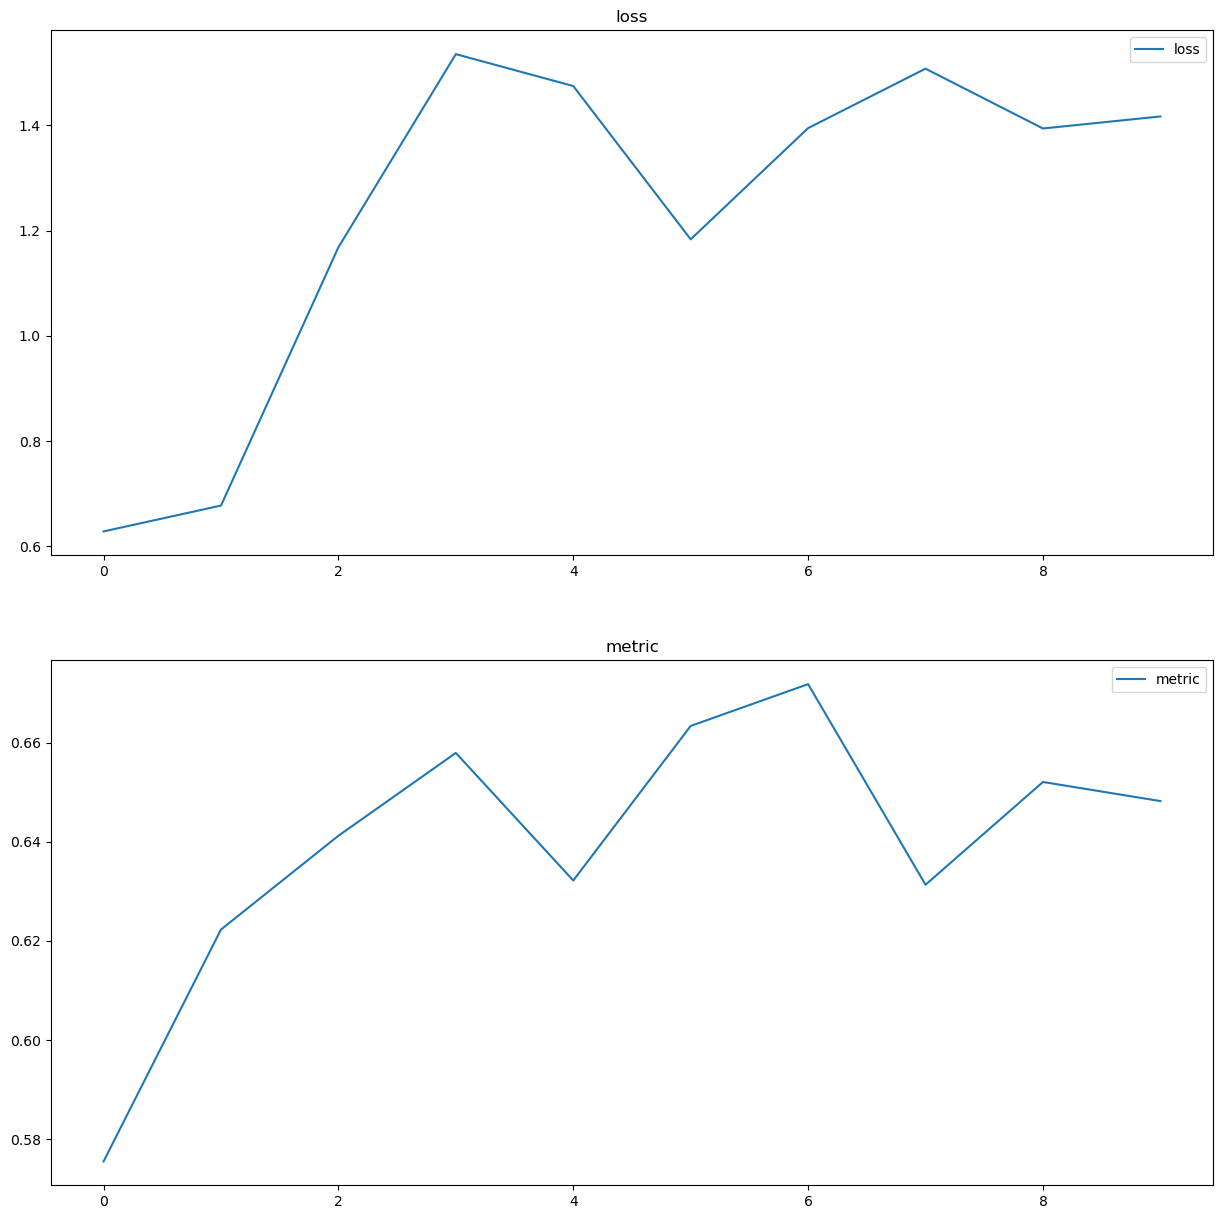

CPU times: user 7min 58s, sys: 28.8 s, total: 8min 26s
Wall time: 12min 55s


In [24]:
%%time

for fold in range(0,num_folds):
    if cv_train == False:
        if fold != 1: 
            continue
    model = build_model()
    model.cuda()
    
    if load_weights:
        model.load_state_dict(torch.load(MODEL_FOLDER / f"{fold}_dict_{om_descr}_{training_phase}.pth"))
    
    train_dataset, valid_dataset, sampler = prepare_datasets(df,fold)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=64,
                                                   num_workers=12,
                                                   pin_memory=True,
                                                   shuffle=False,
                                                   sampler=sampler)

    validation_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                       batch_size=64,
                                                       num_workers=12,
                                                       pin_memory=True,
                                                       shuffle=False)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr,
                                                       steps_per_epoch=len(train_dataloader),epochs=num_epochs)
    
    epoch_loss_values = list()
    metric_values = list()
    
    training_losses = list()
    training_metrices = list()
    

    best_metric = -1
    print("-" * 10)
    print(f"fold {fold + 1}/{num_folds}")    
    
    for epoch in range(1, num_epochs + 1):

        lr_val = optimizer.param_groups[0]["lr"]
        print(f"Fold:{fold} epoch {epoch}/{num_epochs}  LR={lr_val}")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn=f1_torch,
                                                   model=model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        act, pred, _= inferfp32(validation_dataloader, model)
        
        accuracy_metric = accuracy_score(act,pred>0.5)
        sensitivity_metric = recall_score(act,pred>0.1)
        specificity_metric = precision_score(act,pred>0.1)
        auroc_metric = roc_auc_score(act,pred)
        
        
        validation_metric = log_loss(act,pred)

        print(f'Validation--  Metrics: accuracy={accuracy_metric:.5f}, sensitivity={sensitivity_metric:.3f},specificity={specificity_metric:.3f}, auroc={auroc_metric:.3f}', end='\n')
        training_losses.append(training_loss)
        
        epoch_loss_values.append(validation_metric)
        metric_values.append(auroc_metric)
        
        if auroc_metric > best_metric:
            best_metric = auroc_metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_best_dict_{om_descr}_{training_phase}.pth")
            print("saved new best metric model")        
 
    plot_metrics(epoch_loss_values, metric_values)
    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_dict_{om_descr}_{training_phase}.pth")

    model.cpu()
    del model, optimizer, train_dataloader, validation_dataloader, lr_scheduler
    gc.collect()
    torch.cuda.empty_cache()


### Add Tabular

In [25]:
pd.DataFrame({'train_loss':training_losses,'val_loss':epoch_loss_values,'val_auc':metric_values}).to_csv('resnet_audio_exp.csv',index=False)

In [26]:
df

,participant,filename,sound_prediction_score,tb_status,orig_id,fold,path,samples
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254,0,0,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272,0,1,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112,0,2,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152,0,3,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039,0,4,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
...,...,...,...,...,...,...,...,...
9767,CODA_TB_1107,1658214018804-recording-1.wav,0.941761,0,9767,0.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
9768,CODA_TB_1107,1658213992939-recording-1.wav,0.904569,0,9768,0.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
9769,CODA_TB_1107,1658213992139-recording-1.wav,0.934713,0,9769,0.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050
9770,CODA_TB_1107,1658213940569-recording-1.wav,0.912813,0,9770,0.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050


In [27]:
def convert(s):
    lu = {'Male': 1, 'Female':0, 'Yes':1, 'No':0}
    s = s.apply(lambda x:lu[x])
    return(s)

In [28]:
tab_df = pd.read_csv('/kaggle/input/tb-tab-data/CODA_TB_Clinical_Meta_Info.csv')
tab_cols = ['sex', 'age', 'height', 'weight', 'reported_cough_dur',
       'hemoptysis', 'heart_rate', 'temperature', 'weight_loss', 'smoke_lweek',
       'fever', 'night_sweats']

cat_cols = ['sex','hemoptysis', 'weight_loss', 'smoke_lweek','fever', 'night_sweats']

data_df = pd.merge(df, tab_df[['participant']+tab_cols], on = 'participant', how = 'inner')

In [29]:
df = data_df.apply(lambda x: convert(x) if x.name in cat_cols else x)
df

,participant,filename,sound_prediction_score,tb_status,orig_id,fold,path,samples,sex,age,height,weight,reported_cough_dur,hemoptysis,heart_rate,temperature,weight_loss,smoke_lweek,fever,night_sweats
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254,0,0,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050,1,27,173.3,63.0,30,0,99,37.2,1,0,1,1
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272,0,1,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050,1,27,173.3,63.0,30,0,99,37.2,1,0,1,1
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112,0,2,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050,1,27,173.3,63.0,30,0,99,37.2,1,0,1,1
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152,0,3,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050,1,27,173.3,63.0,30,0,99,37.2,1,0,1,1
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039,0,4,2.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050,1,27,173.3,63.0,30,0,99,37.2,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9767,CODA_TB_1107,1658214018804-recording-1.wav,0.941761,0,9767,0.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050,0,50,174.0,87.3,30,0,70,37.0,0,0,1,0
9768,CODA_TB_1107,1658213992939-recording-1.wav,0.904569,0,9768,0.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050,0,50,174.0,87.3,30,0,70,37.0,0,0,1,0
9769,CODA_TB_1107,1658213992139-recording-1.wav,0.934713,0,9769,0.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050,0,50,174.0,87.3,30,0,70,37.0,0,0,1,0
9770,CODA_TB_1107,1658213940569-recording-1.wav,0.912813,0,9770,0.0,/kaggle/input/tb-coughs-audio/data/solicited/1...,22050,0,50,174.0,87.3,30,0,70,37.0,0,0,1,0


In [30]:
#Librosa version
class Dataset_from_df(torch.utils.data.Dataset):
    def __init__(self, file_df, path, crop_length=22050):
        self.file_df = file_df
        self.path = path
        self.crop_length = crop_length
        
        self.tab_cols = ['sex', 'age', 'height', 'weight', 'reported_cough_dur',
                         'hemoptysis', 'heart_rate', 'temperature', 'weight_loss', 'smoke_lweek',
                         'fever', 'night_sweats']
        

    def __len__(self):
        return len(self.file_df)

    def __getitem__(self, index):
        def _randint(a, b):
            return torch.randint(a, b, (1, )).item()
        
        #meta = torchaudio.info(self.path + "/" + df.iloc[index]['subpath'])
        target = self.file_df.iloc[index]['tb_status']*1.0
        length = self.file_df.iloc[index]['samples']
        
        # get tabular data
        tabular = self.file_df.iloc[index][self.tab_cols].to_numpy(dtype='float32')
        
        p = self.path/self.file_df.iloc[index]['filename']
        #p = self.file_df.iloc[index]['path']
        orig_id = self.file_df.iloc[index]['orig_id']

        if length == self.crop_length:
            x, sr = librosa.load(str(p),sr=None)
            
        elif length < self.crop_length:
            s, sr = librosa.load(str(p),sr=None)

            zeros_front = (_randint(0, self.crop_length - length))
            pad_front = np.zeros(( zeros_front))
            pad_back = np.zeros(( self.crop_length - length - zeros_front))
            waveform = np.concatenate((pad_front, s, pad_back), 0)
            x = waveform    
            
            
            
        else:
            crop_start = _randint(0, int(length - self.crop_length))
            x, sr = librosa.load(str(p),sr=None)
            x = x[crop_start:self.crop_length+crop_start]
            
        # transform sound sample to spectrum
        x = np.abs(librosa.stft(x,n_fft = 1024,hop_length=64,window ='hanning'))
        x = librosa.amplitude_to_db(x).astype(np.float32)
        x = (x-np.min(x))/(np.max(x)-np.min(x))
        x = np.flip(x[1:349,:],0).copy() # approx 50Hz to 15000Hz
  
        
        x=torch.from_numpy(x).unsqueeze(0)
        #print(x.shape)
        
        

        return {'x':x, 'sr':sr, 'tabular':tabular,'target':torch.FloatTensor([target, 1.0-target]),'orig_id':orig_id}
    

In [31]:
def prepare_datasets(df, fold):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    
    #balance the data set
    df_counts = pd.DataFrame(train_df.groupby(['tb_status']).size().reset_index()).rename(columns={0:"counts"})
    df_counts['weights'] = df_counts['counts'].max() / df_counts['counts']
    df_balanced = pd.merge(train_df, df_counts[['tb_status','weights']], on='tb_status')
    sampler = torch.utils.data.WeightedRandomSampler(df_balanced['weights'].values, len(df_balanced))

    train_dataset = Dataset_from_df(train_df,TRAIN_FOLDER)
    valid_dataset = Dataset_from_df(valid_df,TRAIN_FOLDER)
    
    return train_dataset, valid_dataset, sampler

In [32]:
class ChannelExpand(torch.nn.Module):
    def __init__(self, channels):
        super(ChannelExpand, self).__init__()
        self.channels = channels
    def forward(self,x):
        #print(x.shape)
        x = x.expand(-1,3,*x.shape[2:])
        
        return x

In [33]:
model = timm.create_model('resnet34', pretrained=True,drop_rate = .50, num_classes=2)
class MultiModel(torch.nn.Module):
    def __init__(self):
        super(MultiModel, self).__init__()
        self.cnn = timm.create_model('resnet34', pretrained=True,drop_rate = .50, num_classes=2)
        self.cnn.fc = torch.nn.Linear(
            self.cnn.fc.in_features, 20)  #modify last layer to 20 features (from 512)
        
        self.fc1 = torch.nn.Linear(20 + 12, 64) # dense layer 
        self.fc2 = torch.nn.Linear(64, 2) # output layer
        
        self.to3_channel = ChannelExpand(3)
        
    def forward(self, image, data):
        image = self.to3_channel(image)
        x1 = self.cnn(image)
        x2 = data
        
        x = torch.cat((x1, x2), dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [34]:
om_descr = 'timm-resnet34-audio_tabular'

def build_model():
    # build a new model
    model = MultiModel()

    
    return model

In [35]:
init_lr = .0005
num_epochs= 10

loss_fn = torch.nn.CrossEntropyLoss()
num_folds = 5
load_weights = False
training_phase = 1

In [36]:
def trainfp32(epoch, train_dataloader, optimizer, loss_fn, lr_scheduler,
              metric_fn, model):



    model.train()

    training_loss = 0
    metric = 0

    m = torch.nn.Softmax(dim=1)
    pbar = tqdm(total=len(train_dataloader))

    for batch in train_dataloader:

        optimizer.zero_grad()


        x = batch['x']
        d = batch['tabular']
        sr = batch['sr']

        y = batch['target']

        x = x.cuda(non_blocking=True)
        d = d.cuda(non_blocking=True)
        y = y.cuda(non_blocking=True)

        output = model(x,d)
        
        loss = loss_fn(m(output), y)

        loss.backward()

        optimizer.step()
        

        lr_scheduler.step()

        training_loss += loss.data.item() * x.size(0)

        metric += metric_fn(y, output) * x.size(0)

        pbar.update(1)
    pbar.close()
    training_loss /= len(train_dataloader.dataset)
    metric /= len(train_dataloader.dataset)
    return training_loss, metric


def inferfp32(valid_dataloader, model):
    act = np.zeros(len(validation_dataloader.dataset))
    pred = np.zeros(len(validation_dataloader.dataset))
    orig_id = np.zeros(len(validation_dataloader.dataset))

    m = torch.nn.Softmax(dim=1)
    
    model.eval()
    pbar = tqdm(total=len(valid_dataloader))

    st = 0
    for batch in valid_dataloader:
        x = batch['x']
        d = batch['tabular']
        sr = batch['sr']
        y = batch['target']
        x = x.cuda(non_blocking=True)
        d = d.cuda(non_blocking=True)
        
        output = model(x,d)
        
        
        en = st + y.shape[0]
        act[st:en] = y[:,0].numpy()
        pred[st:en] = m(output)[:,0].cpu().detach().numpy()
        orig_id[st:en] = batch['orig_id']
        st = en
        
        pbar.update(1)
    pbar.close()
    
    
    return act, pred, orig_id


In [37]:
df['height'][df['height'].isna()] = round(df['height'].mean(),0) # fillna

/tmp/ipykernel_26/3181424362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['height'][df['height'].isna()] = round(df['height'].mean(),0) # fillna


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


----------
fold 2/5
Fold:1 epoch 1/10  LR=1.9999999999999998e-05


100%|██████████| 123/123 [00:56<00:00,  2.19it/s]


Training-- Loss: 0.6052, Metric: 0.705,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Validation--  Metrics: accuracy=0.71556, sensitivity=0.729,specificity=0.351, auroc=0.671
saved new best metric model
Fold:1 epoch 2/10  LR=0.00014059194137776287


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:56<00:00,  2.18it/s]


Training-- Loss: 0.5378, Metric: 0.763,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


Validation--  Metrics: accuracy=0.65375, sensitivity=0.872,specificity=0.349, auroc=0.720
saved new best metric model
Fold:1 epoch 3/10  LR=0.00038118096280056985


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:56<00:00,  2.18it/s]


Training-- Loss: 0.4880, Metric: 0.820,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


Validation--  Metrics: accuracy=0.76008, sensitivity=0.391,specificity=0.501, auroc=0.728
saved new best metric model
Fold:1 epoch 4/10  LR=0.0004999983358164054


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:56<00:00,  2.17it/s]


Training-- Loss: 0.4676, Metric: 0.844,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Validation--  Metrics: accuracy=0.76375, sensitivity=0.358,specificity=0.564, auroc=0.710
Fold:1 epoch 5/10  LR=0.00047484503338568636


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:56<00:00,  2.17it/s]


Training-- Loss: 0.4380, Metric: 0.877,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Validation--  Metrics: accuracy=0.75432, sensitivity=0.445,specificity=0.503, auroc=0.719
Fold:1 epoch 6/10  LR=0.0004051586126118258


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:57<00:00,  2.15it/s]


Training-- Loss: 0.4153, Metric: 0.898,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


Validation--  Metrics: accuracy=0.70980, sensitivity=0.644,specificity=0.424, auroc=0.729
saved new best metric model
Fold:1 epoch 7/10  LR=0.00030474132377695135


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:56<00:00,  2.18it/s]


Training-- Loss: 0.3825, Metric: 0.932,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


Validation--  Metrics: accuracy=0.73284, sensitivity=0.617,specificity=0.452, auroc=0.734
saved new best metric model
Fold:1 epoch 8/10  LR=0.0001934820424720376


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:56<00:00,  2.17it/s]


Training-- Loss: 0.3717, Metric: 0.944,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Validation--  Metrics: accuracy=0.76166, sensitivity=0.439,specificity=0.532, auroc=0.728
Fold:1 epoch 9/10  LR=9.341703386506223e-05


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:56<00:00,  2.17it/s]


Training-- Loss: 0.3643, Metric: 0.950,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Validation--  Metrics: accuracy=0.75380, sensitivity=0.505,specificity=0.497, auroc=0.723
Fold:1 epoch 10/10  LR=2.436540012743118e-05


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 123/123 [00:56<00:00,  2.17it/s]


Training-- Loss: 0.3573, Metric: 0.957,

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


Validation--  Metrics: accuracy=0.74804, sensitivity=0.520,specificity=0.484, auroc=0.723


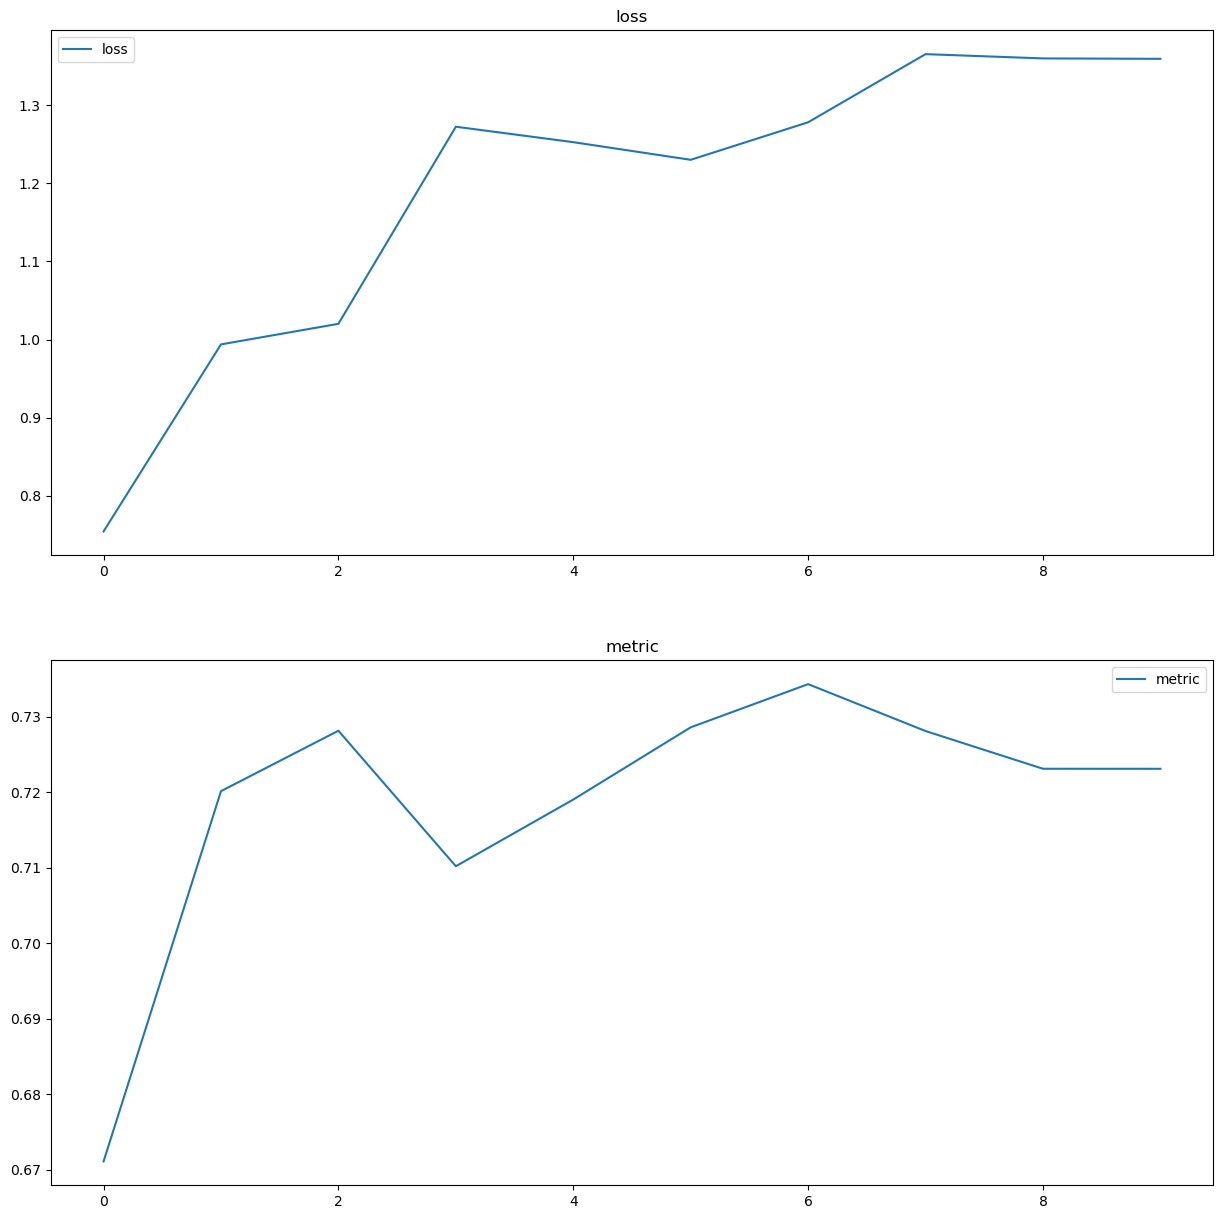

CPU times: user 7min 42s, sys: 27 s, total: 8min 9s
Wall time: 11min 59s


In [38]:
%%time

for fold in range(0,num_folds):
    if cv_train == False:
        if fold != 1: 
            continue
    model = build_model()
    model.cuda()
    
    if load_weights:
        model.load_state_dict(torch.load(MODEL_FOLDER / f"{fold}_dict_{om_descr}_{training_phase}.pth"))
    
    train_dataset, valid_dataset, sampler = prepare_datasets(df,fold)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=64,
                                                   num_workers=12,
                                                   pin_memory=True,
                                                   shuffle=False,
                                                   sampler=sampler)

    validation_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                       batch_size=64,
                                                       num_workers=12,
                                                       pin_memory=True,
                                                       shuffle=False)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr,
                                                       steps_per_epoch=len(train_dataloader),epochs=num_epochs)
    
    epoch_loss_values = list()
    metric_values = list()
    
    training_losses = list()
    training_metrices = list()
    

    best_metric = -1
    print("-" * 10)
    print(f"fold {fold + 1}/{num_folds}")    
    
    for epoch in range(1, num_epochs + 1):

        lr_val = optimizer.param_groups[0]["lr"]
        print(f"Fold:{fold} epoch {epoch}/{num_epochs}  LR={lr_val}")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn=f1_torch,
                                                   model=model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        act, pred, _= inferfp32(validation_dataloader, model)
        
        accuracy_metric = accuracy_score(act,pred>0.5)
        sensitivity_metric = recall_score(act,pred>0.1)
        specificity_metric = precision_score(act,pred>0.1)
        auroc_metric = roc_auc_score(act,pred)
        
        
        validation_metric = log_loss(act,pred)

        print(f'Validation--  Metrics: accuracy={accuracy_metric:.5f}, sensitivity={sensitivity_metric:.3f},specificity={specificity_metric:.3f}, auroc={auroc_metric:.3f}', end='\n')
        training_losses.append(training_loss)
        
        epoch_loss_values.append(validation_metric)
        metric_values.append(auroc_metric)
        
        if auroc_metric > best_metric:
            best_metric = auroc_metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_best_dict_{om_descr}_{training_phase}.pth")
            print("saved new best metric model")        
 
    plot_metrics(epoch_loss_values, metric_values)
    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_dict_{om_descr}_{training_phase}.pth")

    model.cpu()
    del model, optimizer, train_dataloader, validation_dataloader, lr_scheduler
    gc.collect()
    torch.cuda.empty_cache()


In [39]:
pd.DataFrame({'train_loss':training_losses,'val_loss':epoch_loss_values,'val_auc':metric_values}).to_csv('resnet_audio_exp.csv',index=False)